In this notebook, we read the raw twitter data and keep the clean tweets only.

After that we filter the tweets by only keeping swiss tweets using a bounding box to reduce the amount of tweets before running a canton mapping(in this stage we are also capturing some tweets out side of Switzerland given the shape of Switzerland on the map).

Then we use the geogason file of Switzerland to exteract the boundaries of swiss cantons and then we store them in range trees and using a computational geometry library (shapely) we were able to query the locations of tweets and map them to a cantons.

At the end we show the number of tweets for each canton, Geneve has the highest number of tweets!

In [1]:
import pandas as pd 
import csv
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
tweets=pd.read_csv('twitter_data/twex.tsv', sep='\t', escapechar='\\',quoting=csv.QUOTE_NONE, encoding='utf-8') 

In [3]:
schema=['id','userId','createdAt','text','longitude','latitude','placeId','inReplyTo','source','truncated','placeLatitude',
        'placeLongitude','sourceName','sourceUrl','userName','screenName','followersCount','friendsCount',
        'statusesCount','userLocation']
tweets.columns=schema

In [4]:
tweets.shape

(28799234, 20)

In [4]:
tweets.shape

(28799234, 20)

In [5]:
bad_lines=tweets[~tweets['id'].apply(lambda x: str(x).isdigit())]

In [6]:
len(bad_lines)

3236313

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


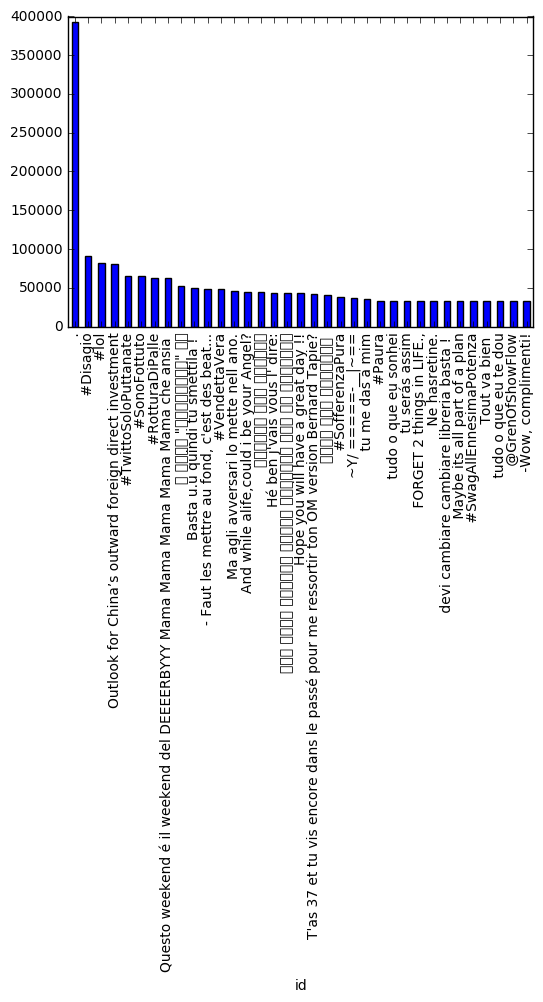

In [7]:
bb=pd.DataFrame()
bb=bad_lines.groupby('id').size()
bb=bb.reset_index()
bb=bb.sort(0, ascending=False)
bb=bb.set_index('id')
bb.head(35)[0].plot(kind='bar')

In [8]:
tweets=tweets[tweets['id'].apply(lambda x: str(x).isdigit())]

In [9]:
len(tweets)

25562921

In [16]:
#keep only tweets where we can get the longitude and longitude infotmation!

tweets=tweets[((~tweets['longitude'].isnull()) & (~tweets['longitude'].isnull()) 
      |
    ((~tweets['placeLongitude'].isnull()) & (~tweets['placeLatitude'].isnull())))
    ]



In [17]:
len(tweets)

20213917

In [16]:
tweets[tweets['text'].isnull()].head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,source,truncated,placeLatitude,placeLongitude,sourceName,sourceUrl,userName,screenName,followersCount,friendsCount,statusesCount,userLocation
98935,139617005438373889,1.36884e+07,2011-11-24 08:11:02,NaN,9.85637,46.5108,ac6076971b2eebb6,N,1,NaN,46.5029,9.842,Twitter for iPhone,http://twitter.com/#!/download/iphone,Natalia Panatti ॐ,NataliaPanatti,239,538.0,5423.0,Chiavenna (SO)
98977,139635637916667905,1.43315e+07,2011-11-24 09:25:05,NaN,7.27869,47.1261,7fa3f3e1d7ed1f94,N,7,NaN,47.1283,7.27933,Instagram,http://instagr.am,يbحaص ¯\_(ツ)_/¯,sa7bi,505,975.0,6806.0,Switzerland / Tunisia
102300,143619407971749888,1.36884e+07,2011-12-05 09:15:09,NaN,9.39227,46.3195,7ce65f2c326f5e80,N,1,NaN,46.3293,9.4055,Twitter for iPhone,http://twitter.com/#!/download/iphone,Natalia Panatti ॐ,NataliaPanatti,239,538.0,5423.0,Chiavenna (SO)
102579,143955091458768897,1.63291e+07,2011-12-06 07:29:03,NaN,7.15925,46.8048,2f41eda3156d6485,N,1,NaN,46.8031,7.15962,Twitter for iPhone,http://twitter.com/#!/download/iphone,AoS,AoStefan,227,177.0,4502.0,Switzerland
103218,144526968120020992,1.36884e+07,2011-12-07 21:21:29,NaN,9.82434,46.4828,c1830fd6f521464e,N,1,NaN,46.4861,9.80696,Twitter for iPhone,http://twitter.com/#!/download/iphone,Natalia Panatti ॐ,NataliaPanatti,239,538.0,5423.0,Chiavenna (SO)


In [18]:
#keep only tweets that have text information
tweets=tweets[tweets['text'].notnull()]

In [19]:
len(tweets)

20028326

In [ ]:
tweets['longitude']=tweets.longitude.convert_objects(convert_numeric=True)
tweets['latitude']=tweets.latitude.convert_objects(convert_numeric=True)
tweets['placeLatitude']=tweets.placeLatitude.convert_objects(convert_numeric=True)
tweets['placeLongitude']=tweets.placeLongitude.convert_objects(convert_numeric=True)

In [21]:
len(tweets)

20028326

In [22]:
#keep only tweets that have been posted inside Switzerland..  simple bounding box filteration..
#in this filteration we still have some tweets from other countries since the bounding box cover some other countries..

tweets['swiss']='no'
tweets.ix[((tweets.latitude>= 45.818) & 
         (tweets.latitude<=47.8084) & 
         (tweets.longitude>=5.9559) &
         (tweets.longitude<=10.4921)) |
         ((tweets.placeLatitude>= 45.818) & 
         (tweets.placeLatitude<=47.8084) & 
         (tweets.placeLongitude>=5.9559) &
         (tweets.placeLongitude<=10.4921))
         , 'swiss'] = 'yes'

In [23]:
tweets=tweets[tweets['swiss']=='yes']
len(tweets)

19210392

In [24]:
tweets.to_csv("swiss_tweets_jan_6th.csv", index=None)

In [ ]:
tweets=pd.read_csv("swiss_tweets_jan_6th.csv")

In [3]:
len(tweets)

19210392

In [4]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,source,truncated,...,placeLongitude,sourceName,sourceUrl,userName,screenName,followersCount,friendsCount,statusesCount,userLocation,swiss
0,9.514846e+09,7198282.0,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,N,N,550.0,NaN,...,NaN,Gowalla,http://gowalla.com/,Nico Luchsinger,halbluchs,1820.0,703.0,4687.0,"Zurich, Switzerland",yes
1,9.516574e+09,14657884.0,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,N,N,3.0,NaN,...,NaN,foursquare,http://foursquare.com,Javier Belmonte,vichango,167.0,277.0,2885.0,"Geneva, Switzerland",yes
2,9.516953e+09,14703863.0,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,N,N,62.0,NaN,...,NaN,Twittelator,http://stone.com/Twittelator,Urs,ugro,75.0,161.0,1390.0,"Zürich, Switzerland",yes
3,9.517199e+09,14393717.0,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,N,N,3.0,NaN,...,NaN,foursquare,http://foursquare.com,Romain P.,PIMboula,135.0,109.0,2381.0,"Lausanne, Suisse",yes
4,9.517917e+09,13535402.0,2010-02-23 08:35:39,I'm at Online PC Magazin in Adliswil http://go...,8.53010,47.3152,N,N,550.0,NaN,...,NaN,Gowalla,http://gowalla.com/,Patrick Hediger,hediger,1511.0,682.0,12157.0,"Zurich, Switzerland",yes


## Assigning tweets to cantons

In [5]:
#Here we try to assign tweets to cantons using the location information avaiable in tweets using the geojson file of 
# switzerland and the help of shapely library

import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
#with open('swiss.geojson.json') as f:
with open('canton_mapping_tests/swiss-simple.geojson.json' ) as f: #swiss.geojson.json
    js = json.load(f,encoding = "ISO-8859-1")

# construct point based on lon/lat returned by geocoder
#point = Point(-122.7924463, 45.4519896)

polygons_dict = {}

# check each polygon to see if it contains the point
for feature in js['features']:
    polygon = shape(feature['geometry'])
    polygons_dict[feature['id']] = polygon
    
id_to_label = dict(zip(range(len(polygons_dict.items())),polygons_dict.keys()))
id_to_poly = {num:polygons_dict[id_to_label[num]] for num in id_to_label.keys()}
id_to_poly

#coordinates_df = coordinates_df.dropna(axis=0)



{0: <shapely.geometry.multipolygon.MultiPolygon at 0x10d8345f8>,
 1: <shapely.geometry.multipolygon.MultiPolygon at 0x10d834390>,
 2: <shapely.geometry.multipolygon.MultiPolygon at 0x10d834710>,
 3: <shapely.geometry.multipolygon.MultiPolygon at 0x10d834668>,
 4: <shapely.geometry.polygon.Polygon at 0x10d8342e8>,
 5: <shapely.geometry.polygon.Polygon at 0x10d834400>,
 6: <shapely.geometry.polygon.Polygon at 0x10d834748>,
 7: <shapely.geometry.polygon.Polygon at 0x10d8348d0>,
 8: <shapely.geometry.polygon.Polygon at 0x10d8343c8>,
 9: <shapely.geometry.polygon.Polygon at 0x10d8347f0>,
 10: <shapely.geometry.polygon.Polygon at 0x10d834828>,
 11: <shapely.geometry.multipolygon.MultiPolygon at 0x10d834470>,
 12: <shapely.geometry.polygon.Polygon at 0x10d8344e0>,
 13: <shapely.geometry.multipolygon.MultiPolygon at 0x10d834898>,
 14: <shapely.geometry.multipolygon.MultiPolygon at 0x10d8342b0>,
 15: <shapely.geometry.polygon.Polygon at 0x10d834438>,
 16: <shapely.geometry.multipolygon.MultiPol

In [6]:
from rtree import index

idx = index.Index()
for pos, poly in id_to_poly.items():
    idx.insert(pos, poly.bounds)

In [7]:
def get_canton(row):
    lon=row['longitude']
    lat=row['latitude']
    if(str(lon)=='nan'):
        lon=row['placeLongitude']
        lat=row['placeLatitude']
    #point = Point(row['longitude'], row['latitude'])
    point = Point(lon, lat)
    # iterate through spatial index
    for j in idx.intersection(point.coords[0]):
        if point.within(id_to_poly[j]):
            return id_to_label[j]
            #print(id_to_label[j], point)
    return None

In [8]:
%%time
tweets['canton'] = tweets.apply(get_canton, axis=1)
#6:05

CPU times: user 2h 32min 34s, sys: 1min 54s, total: 2h 34min 29s
Wall time: 2h 35min 48s


In [10]:
tweets.to_csv("canton_mapping_6_jan_all.csv", index=None)

In [12]:
tweets=tweets[~tweets['canton'].isnull()]

In [13]:
tweets.to_csv('canton_mapping_6_jan_swiss.csv', index=None)

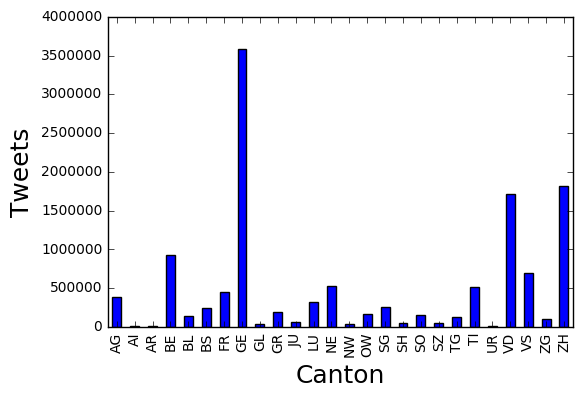

In [14]:
# to look at the number of tweets distribution per canton... interstingly we found that Geneve has the highest # of tweets
a=tweets.groupby(['canton']).agg(['count'])
ax=tweets.groupby('canton').size().plot(kind='bar')
plt.xlabel('Canton',fontsize=18)
plt.ylabel('Tweets',fontsize=18)